In [316]:
%matplotlib inline
import cd_diagrams as cdd
import importlib
import pandas as pd
import numpy as np
import amir_tools as at
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import functools as ft
import matplotlib
import warnings
matplotlib.rc_file_defaults()
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
models = ["inception","minirocket","xresnet1d101"]

In [644]:
def get_scaling_experiments(model_name,dataset,clf_numbers=True,dataset_numbers=True):
    # loads the experiment results
    experiments = []
    for sc in ["0.1","0.25","0.5","0.75","1.0"]:
        try:
            for i in range(20):
                df = pd.read_csv("models/scaling/csvs/%s_%s_sc-n_%s_%s.csv"%(model_name,dataset,sc,i))
                df = df[df.columns[0:-4]]
                df = df.loc[df["index"]=="f1-score"]
                df = df.rename(columns={"index":"classifier_name"})
                df["classifier_name"] = model_name if clf_numbers==False else "%s_%s"%(model_name,sc)
                df["dataset_name"] = dataset if dataset_numbers==False else "%s_%s"%(dataset,i)
                df.index = [i]
                experiments.append(df)
        except Exception as  e:
            print(e)
            continue
    exp_df = pd.concat(experiments)
    return exp_df

def make_cdd_df(exp_df):
    df_median = exp_df.reset_index()[["classifier_name","dataset_name",]]
    df_median["value"] = list(exp_df[exp_df.columns[1:-1]].mean(axis=1).values)
    df_median.columns = ["classifier_name","dataset_name","accuracy"]
    return df_median

def cd_diagram_single_model(exp_df,title="Mean F1",labels=False):
    df_median = make_cdd_df(exp_df)
    cdd.draw_cd_diagram(df_perf=df_median, title=title, labels=labels,alpha=0.05)
    
def draw_scatter_plot(exp_df):
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.set(font_scale = 3)
    data = exp_df.melt(id_vars = "classifier_name")
    data["variable"] = [at.label_shortner(x) for x in data["variable"]]

    #sns.boxplot(data=data,hue="classifier_name",x="variable",y="value",)
    ax = sns.stripplot(data=data,hue="classifier_name",x="variable",y="value",dodge=True,size=8, edgecolor='gray',)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=45)
    ax.set_xlabel("", fontsize = 25)
    ax.set_ylabel("F1 Values", fontsize = 25)
    # ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)
#     plt.legend( fontsize = 16)
#     plt.tight_layout()
    ax.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    return plt

## per model analysis

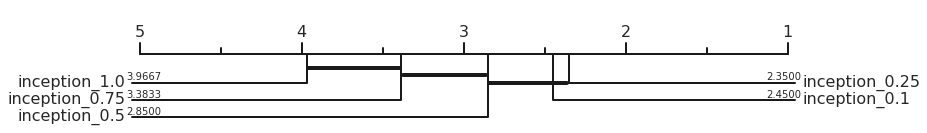

In [781]:
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
inception_dfs = []
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset)
    inception_dfs.append(exp_df)
df_inception = pd.concat([make_cdd_df(x) for x in inception_dfs])
plt = cdd.draw_cd_diagram(df_perf=df_inception,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

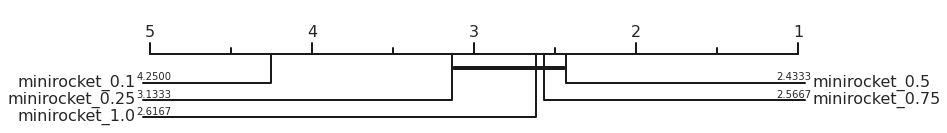

In [782]:
minirocket_dfs = []
for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset)
    minirocket_dfs.append(exp_df)
df_minirocket = pd.concat([make_cdd_df(x) for x in minirocket_dfs])
plt = cdd.draw_cd_diagram(df_perf=df_minirocket,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

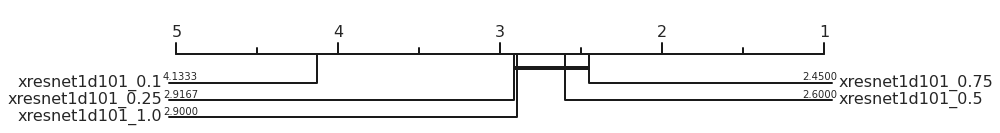

In [783]:
xresnet_dfs = []
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset)
    xresnet_dfs.append(exp_df)
df_xresnet = pd.concat([make_cdd_df(x) for x in xresnet_dfs])
plt = cdd.draw_cd_diagram(df_perf=df_xresnet,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

# per disease analysis

In [375]:
# first, select a dataset
# treat each disease as its own dataset, and run the cd analysis for all models. 
# classifier_name -> model+sc
# dataset_name -> disease+dataset (in case there are duplicates)
# acc -> F1 measure

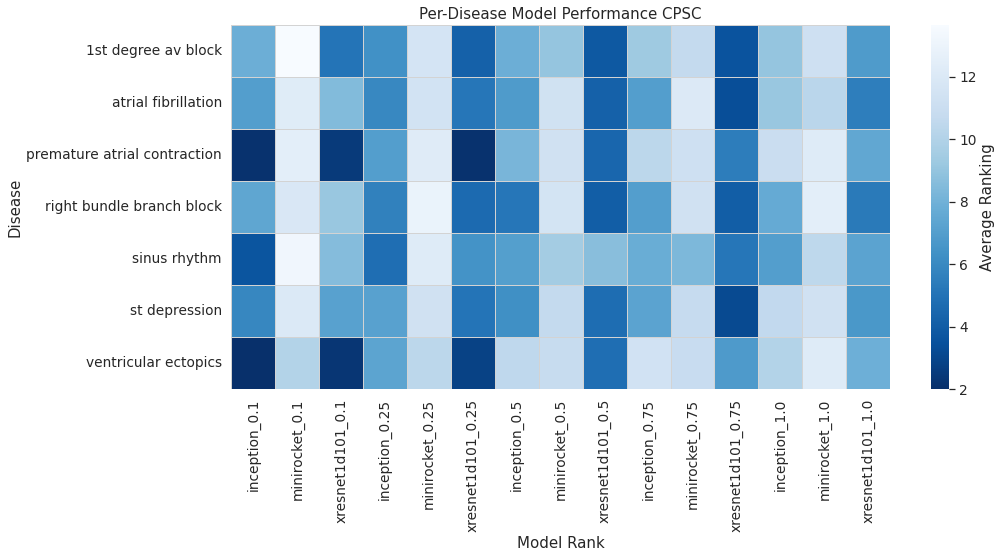

In [720]:
from matplotlib.colors import LinearSegmentedColormap

dset_num = 1 # 0->chapman,1->cpsc, 2->ptbxl
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
disease_list = minirocket_dfs[dset_num].columns[1:-1]
dataset_dfs = []
df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
# now for each disease in disease_list, do the analysis
disease_dict = {}
for disease_name in disease_list:
    df_perf = df[["classifier_name","dataset_name",disease_name]]
    df_perf = df_perf.rename(columns={disease_name:"accuracy"})
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        disease_dict[disease_name] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05)[1]

hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([float(i.split("_")[-1]) for i in hm_df.columns])]] # sort by scaling value

ax = sns.heatmap(hm_df, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True).reversed())

sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 1.25)

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-1, 0, 1])
# colorbar.set_ticklabels(['B', 'A', 'C'])
# X - Y axis labels
ax.set_ylabel('Disease')
ax.set_xlabel('Model Rank')
ax.set_title("Per-Disease Model Performance %s"%dataset_names[dset_num])
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([])

colorbar.ax.set_ylabel('Average Ranking',)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
# _, labels = plt.yticks()
# plt.setp(labels, rotation=0)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/Per-Disease_Model_Performance_%s.pdf'%dataset_names[dset_num])

In [773]:
# all datasets combined 

dset_num = 2 # 0->chapman,1->cpsc, 2->ptbxl
dataset_names = {0:"chapman",1:"CPSC",2:"PTBXL"}

disease_dict = {}
for dset_num in range(3):
    disease_list = minirocket_dfs[dset_num].columns[1:-1]
    df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
    # now for each disease in disease_list, do the analysis

    for disease_name in disease_list:
        df_perf = df[["classifier_name","dataset_name",disease_name]]
        df_perf = df_perf.rename(columns={disease_name:"accuracy"})
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disease_dict[disease_name+"-"+dataset_names[dset_num]] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05)[1]



hm_df = pd.DataFrame(disease_dict).T
hm_df

,inception_0.1,inception_0.25,inception_0.5,inception_0.75,inception_1.0,minirocket_0.1,minirocket_0.25,minirocket_0.5,minirocket_0.75,minirocket_1.0,xresnet1d101_0.1,xresnet1d101_0.25,xresnet1d101_0.5,xresnet1d101_0.75,xresnet1d101_1.0
atrial fibrillation-chapman,7.850,6.600,5.000,4.650,5.100,14.000,11.650,13.050,11.850,11.450,8.150,7.300,5.800,4.450,3.100
left ventricular high voltage-chapman,7.800,8.850,9.700,9.350,10.250,6.250,4.550,3.650,3.750,3.550,12.700,12.050,9.375,8.500,9.675
nonspecific st t abnormality-chapman,7.900,8.175,8.550,7.575,8.600,5.250,8.000,6.950,7.000,6.600,13.550,9.950,9.450,7.425,5.025
sinus bradycardia-chapman,4.200,3.400,11.375,12.750,14.550,9.375,8.400,7.175,8.925,10.025,6.750,7.525,5.900,3.625,6.025
sinus rhythm-chapman,4.000,3.800,9.600,12.450,14.550,9.750,8.200,8.325,10.150,8.100,7.150,9.000,5.450,4.200,5.275
sinus tachycardia-chapman,7.300,4.800,4.800,7.200,10.650,11.225,7.800,10.225,12.625,9.925,10.600,8.375,5.350,4.850,4.275
supraventricular tachycardia-chapman,5.350,5.300,8.850,8.850,6.925,11.450,11.175,10.725,11.100,12.300,7.525,7.650,5.150,3.575,4.075
t wave abnormal-chapman,9.150,6.350,7.650,7.150,6.600,8.050,6.700,5.750,7.450,5.750,13.350,12.175,8.150,8.000,7.725
1st degree av block-CPSC,7.850,6.325,7.850,9.300,9.025,13.650,11.600,9.025,10.675,11.200,5.050,4.225,3.850,3.550,6.825
atrial fibrillation-CPSC,6.975,5.950,6.850,6.975,9.125,12.275,11.425,11.350,12.050,10.325,8.500,5.175,4.225,3.325,5.475


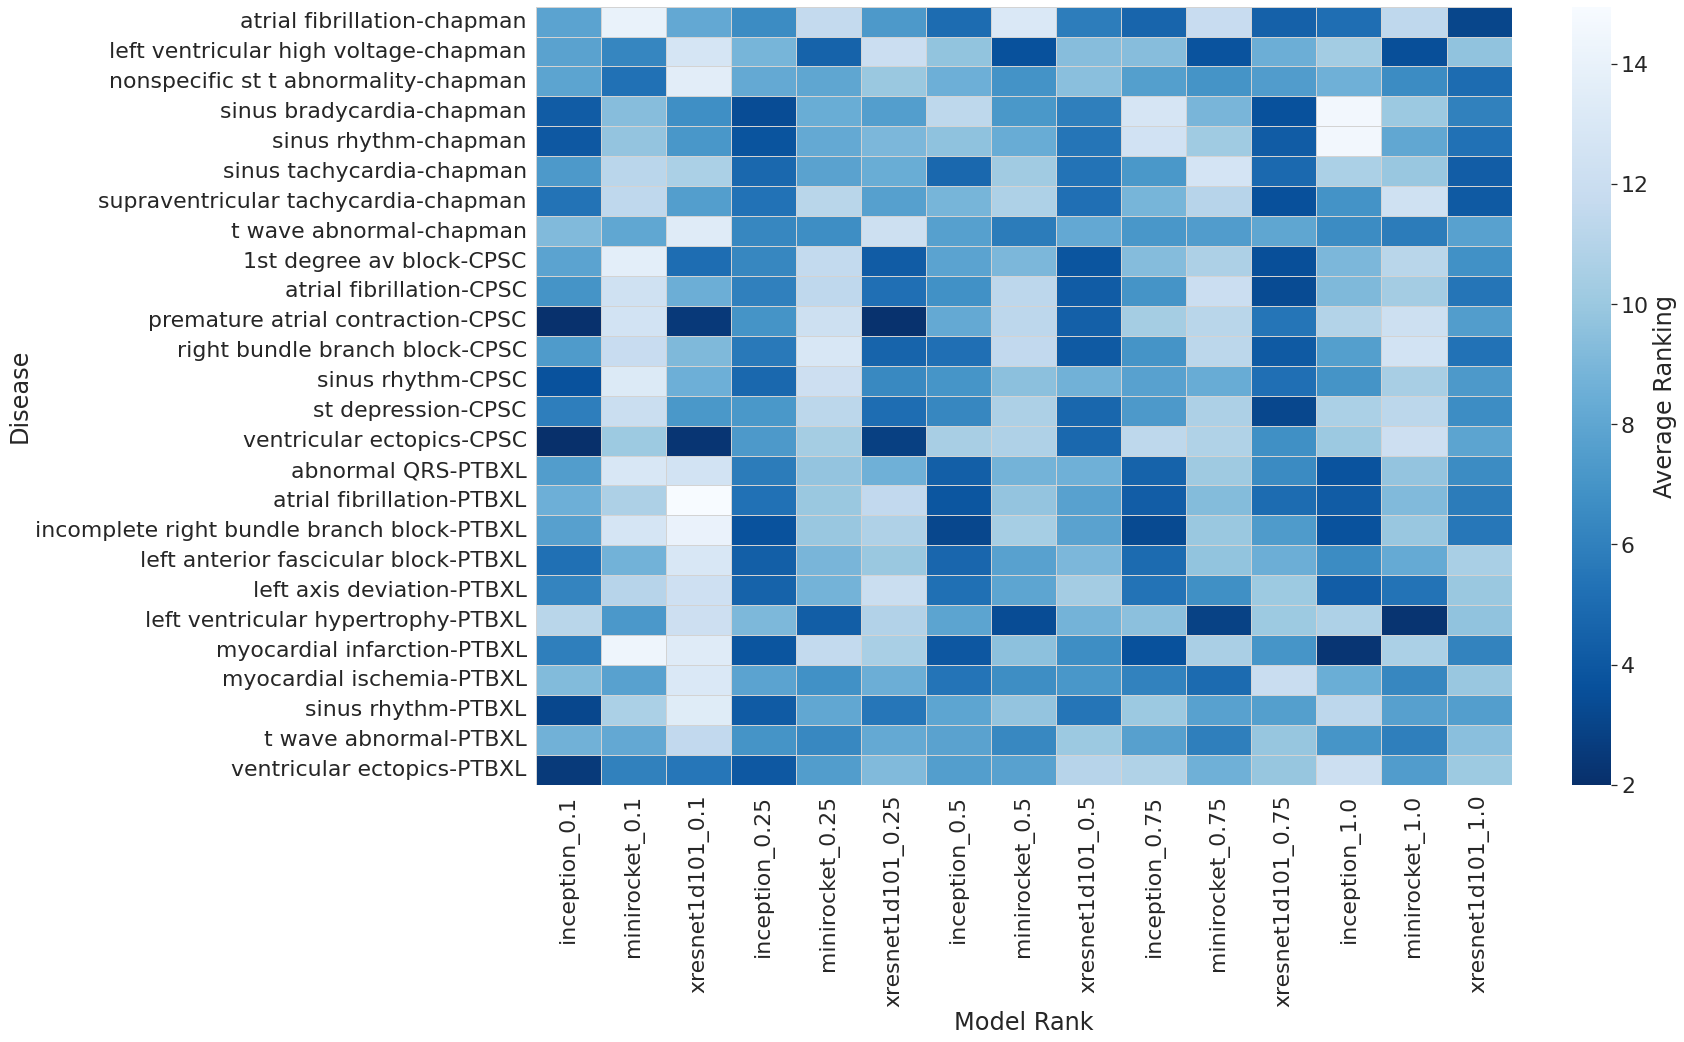

In [775]:
hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([float(i.split("_")[-1]) for i in hm_df.columns])]] # sort by scaling value

ax = sns.heatmap(hm_df, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True).reversed())

sns.set(rc = {'figure.figsize':(25,15)})
sns.set(font_scale = 2)

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-1, 0, 1])
# colorbar.set_ticklabels(['B', 'A', 'C'])
# X - Y axis labels
ax.set_ylabel('Disease')
ax.set_xlabel('Model Rank')
# ax.set_title("Per-Disease Model Performance "%dataset_names[dset_num])
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([])

colorbar.ax.set_ylabel('Average Ranking',)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
# _, labels = plt.yticks()
# plt.setp(labels, rotation=0)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/Per-Disease_Model_Performance_all.pdf')

## per dataset analysis
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1

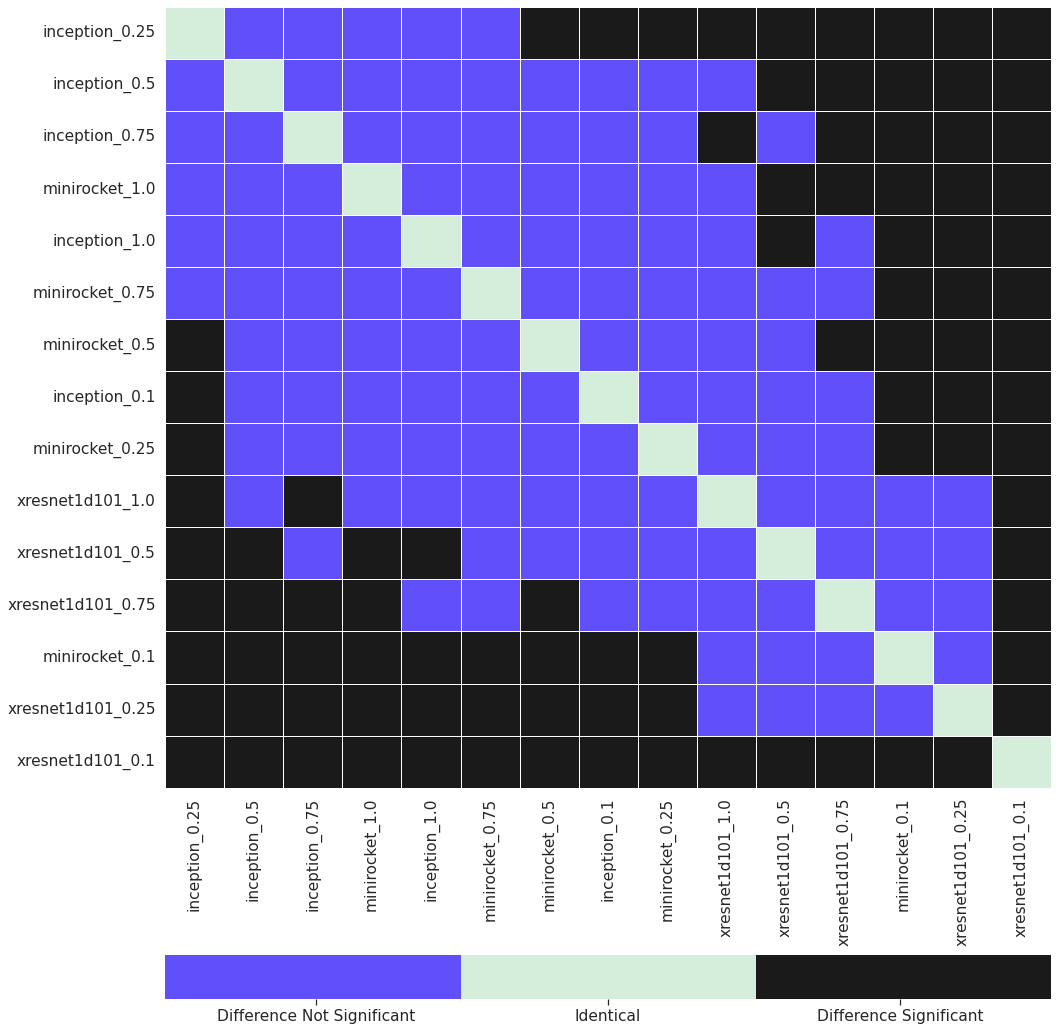

In [784]:
dataset = "PTBXL"
dataset_dfs = []
for model_name in models[0:3]:
    exp_df = get_scaling_experiments(model_name,dataset)
    dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
            
myColors = ((0.1, 0.0, 1, 0.66),(0.5, 1, .5,0.2),(0.1, 0.1, 0.1, 1),)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.set(rc = {'figure.figsize':(15,16)})
sns.set(font_scale = 1.4)
ax = sns.heatmap(rank_matrix, cmap=cmap, linewidths=0.5,cbar_kws={"orientation": "horizontal"})
# ax.set_title("Model Comparisons for %s"%dataset)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.66, 0, .66])

colorbar.set_ticklabels(['Difference Not Significant', 'Identical', 'Difference Significant'])
ax.tick_params(axis='x', rotation=90)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/model_comparisons_%s.pdf'%dataset)

## all models, all datasets
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1
### Method 1, pool all performane dfs together and run test
### Method 2, get rank matrices, and average them 

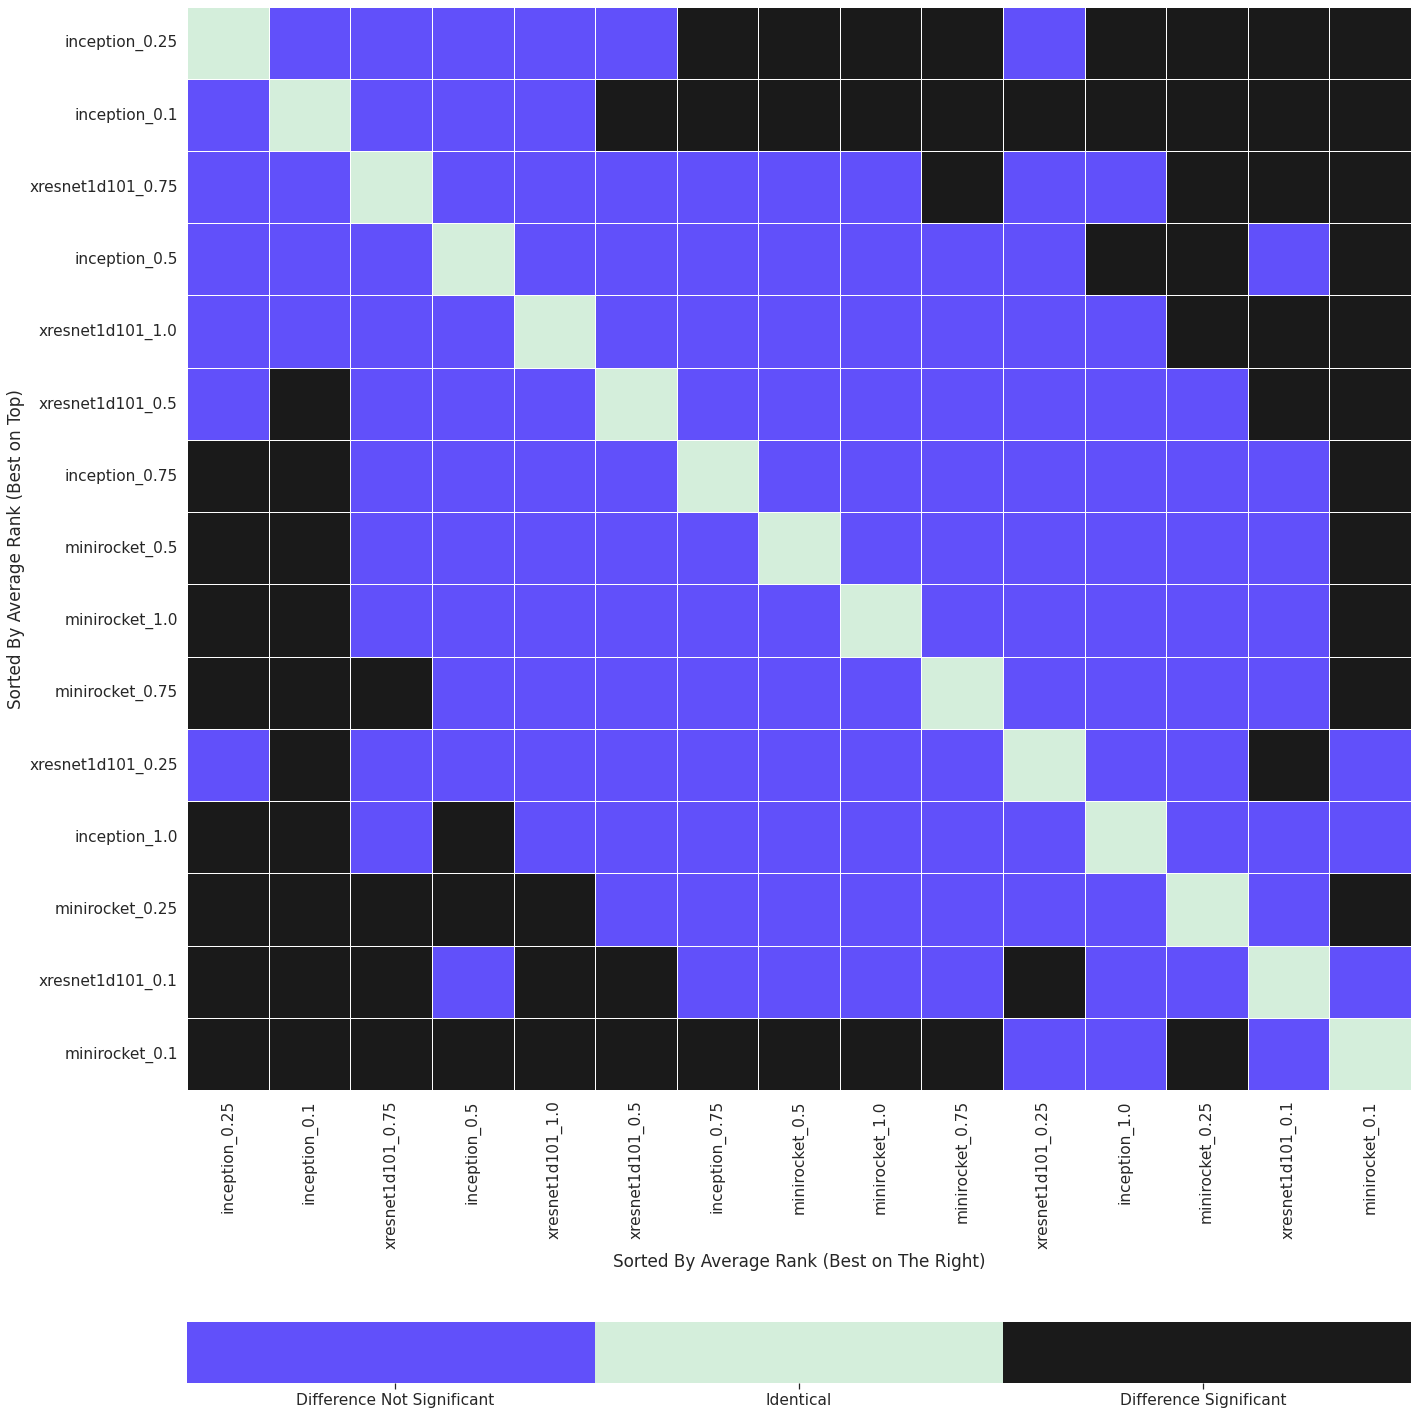

In [790]:
dataset_dfs = []
for model_name in models[0:3]:
    for dataset in datasets:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
myColors = ((0.1, 0.0, 1, 0.66),(0.5, 1, .5,0.2),(0.1, 0.1, 0.1, 1),)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.set(rc = {'figure.figsize':(20,22)})
sns.set(font_scale = 1.4)
ax = sns.heatmap(rank_matrix, cmap=cmap, linewidths=0.5,cbar_kws={"orientation": "horizontal"})
# ax.set_title("Model Comparisons for All Datasets")
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.66, 0, .66])

colorbar.set_ticklabels(['Difference Not Significant', 'Identical', 'Difference Significant'])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Sorted By Average Rank (Best on Top)')
ax.set_xlabel('Sorted By Average Rank (Best on The Right)')
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/model_comparisons_alldatasets.pdf')

In [626]:
# Method 2
dataset_dfs = []
avg_ranks = []
for dataset in datasets:
    for model_name in models[0:3]:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
    p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
    avg_ranks.append(avg_rank)
(sum(avg_ranks)/len(avg_ranks)).sort_values()

inception_0.1         5.075000
inception_0.25        5.172222
xresnet1d101_0.75     5.380556
xresnet1d101_1.0      5.755556
xresnet1d101_0.5      6.672222
minirocket_0.5        7.675000
inception_0.5         7.847222
minirocket_1.0        8.391667
minirocket_0.75       8.472222
inception_0.75        8.494444
minirocket_0.25       8.891667
xresnet1d101_0.25     9.216667
inception_1.0        10.441667
minirocket_0.1       11.150000
xresnet1d101_0.1     11.363889
dtype: float64

# other stuff

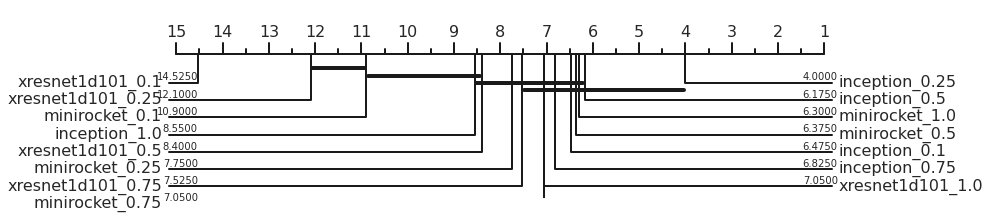

In [113]:
importlib.reload(cdd)
df_perf = pd.concat([df_xresnet,df_inception,df_minirocket])
plt,p_vals,avg_rank = cdd.draw_cd_diagram(df_perf=df_perf,alpha=0.05,labels=True,)

In [124]:
stats = pd.DataFrame(p_vals,columns=["model_1","model_2","p_val","significant"])
# stats[(stats["model_1"]=="inception_1.0")]
avg_rank

xresnet1d101_0.1     14.525
xresnet1d101_0.25    12.100
minirocket_0.1       10.900
inception_1.0         8.550
xresnet1d101_0.5      8.400
minirocket_0.25       7.750
xresnet1d101_0.75     7.525
minirocket_0.75       7.050
xresnet1d101_1.0      7.050
inception_0.75        6.825
inception_0.1         6.475
minirocket_0.5        6.375
minirocket_1.0        6.300
inception_0.5         6.175
inception_0.25        4.000
dtype: float64

# scatter plots

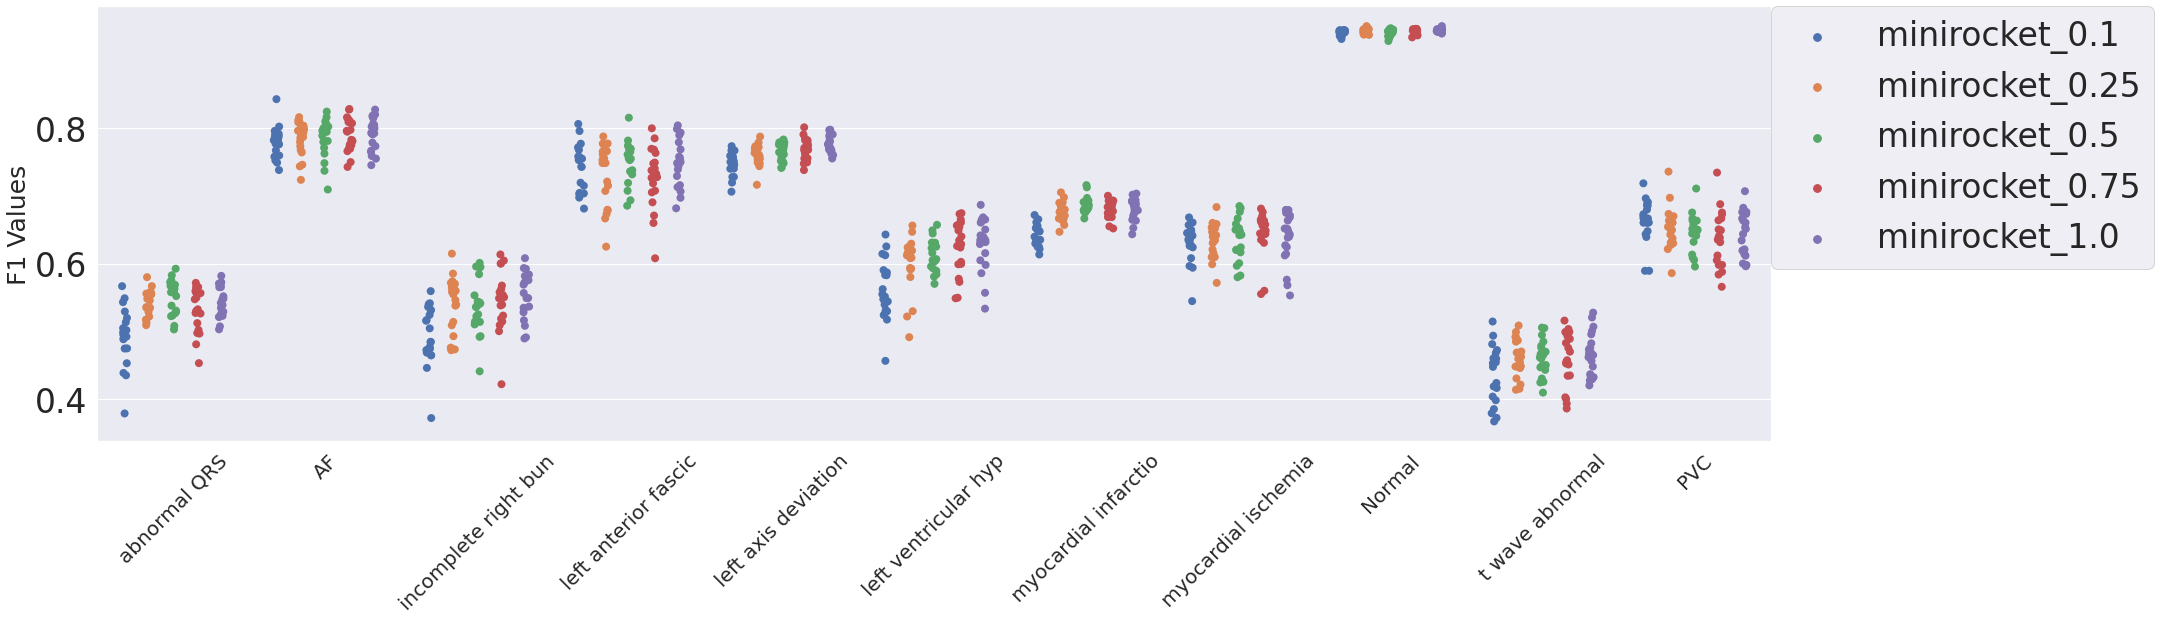

In [643]:

for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

Text(0.5, 1.0, 'Expriment Results for MiniRocket on CPSC')

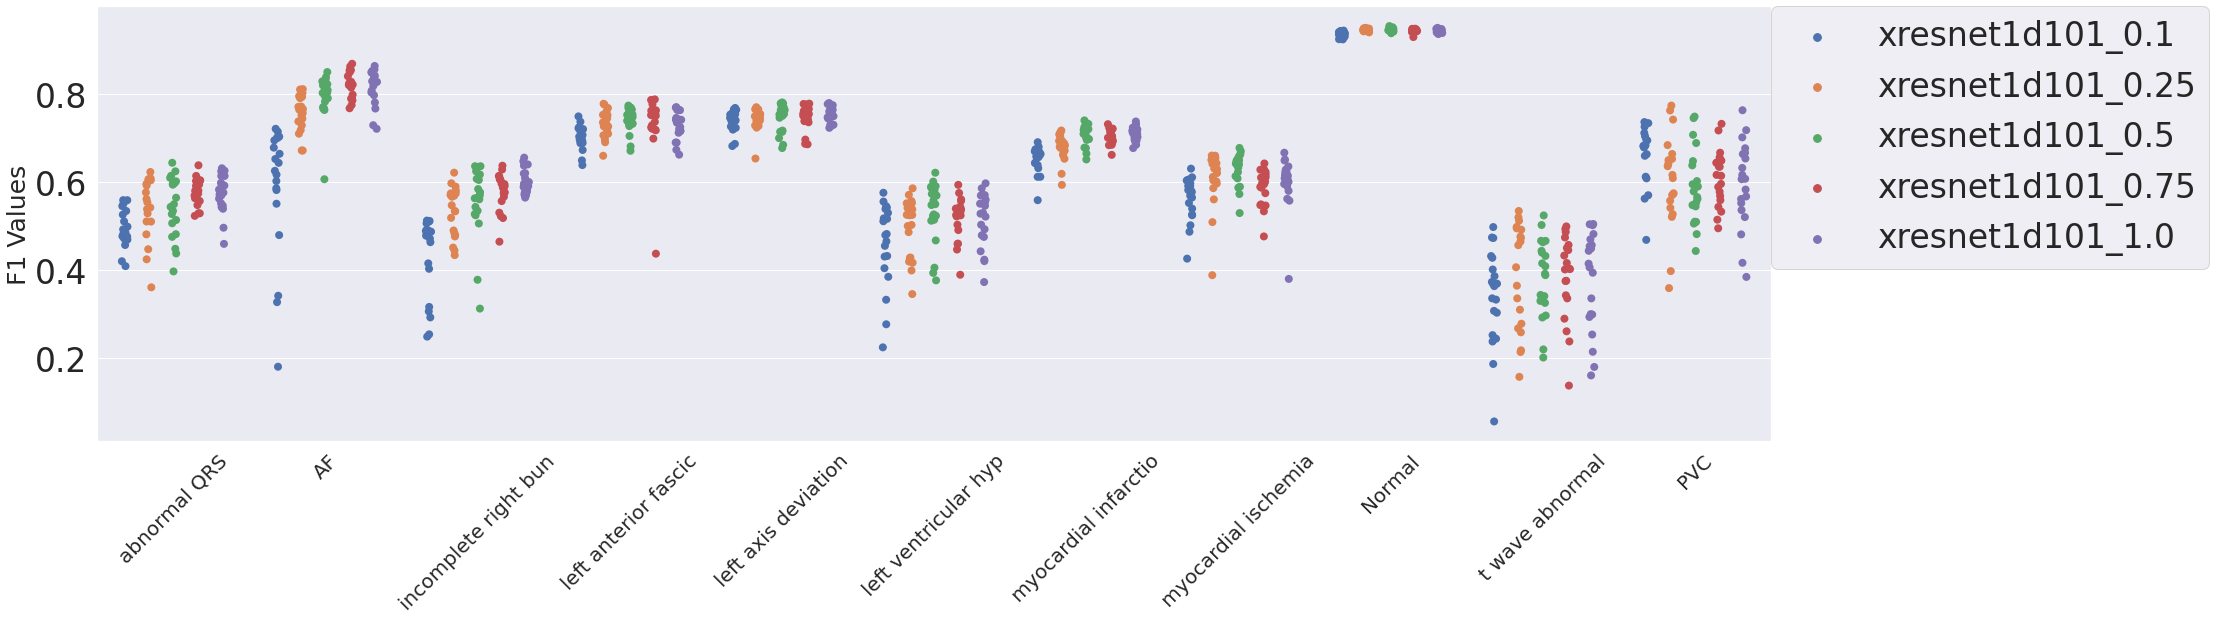

In [645]:
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

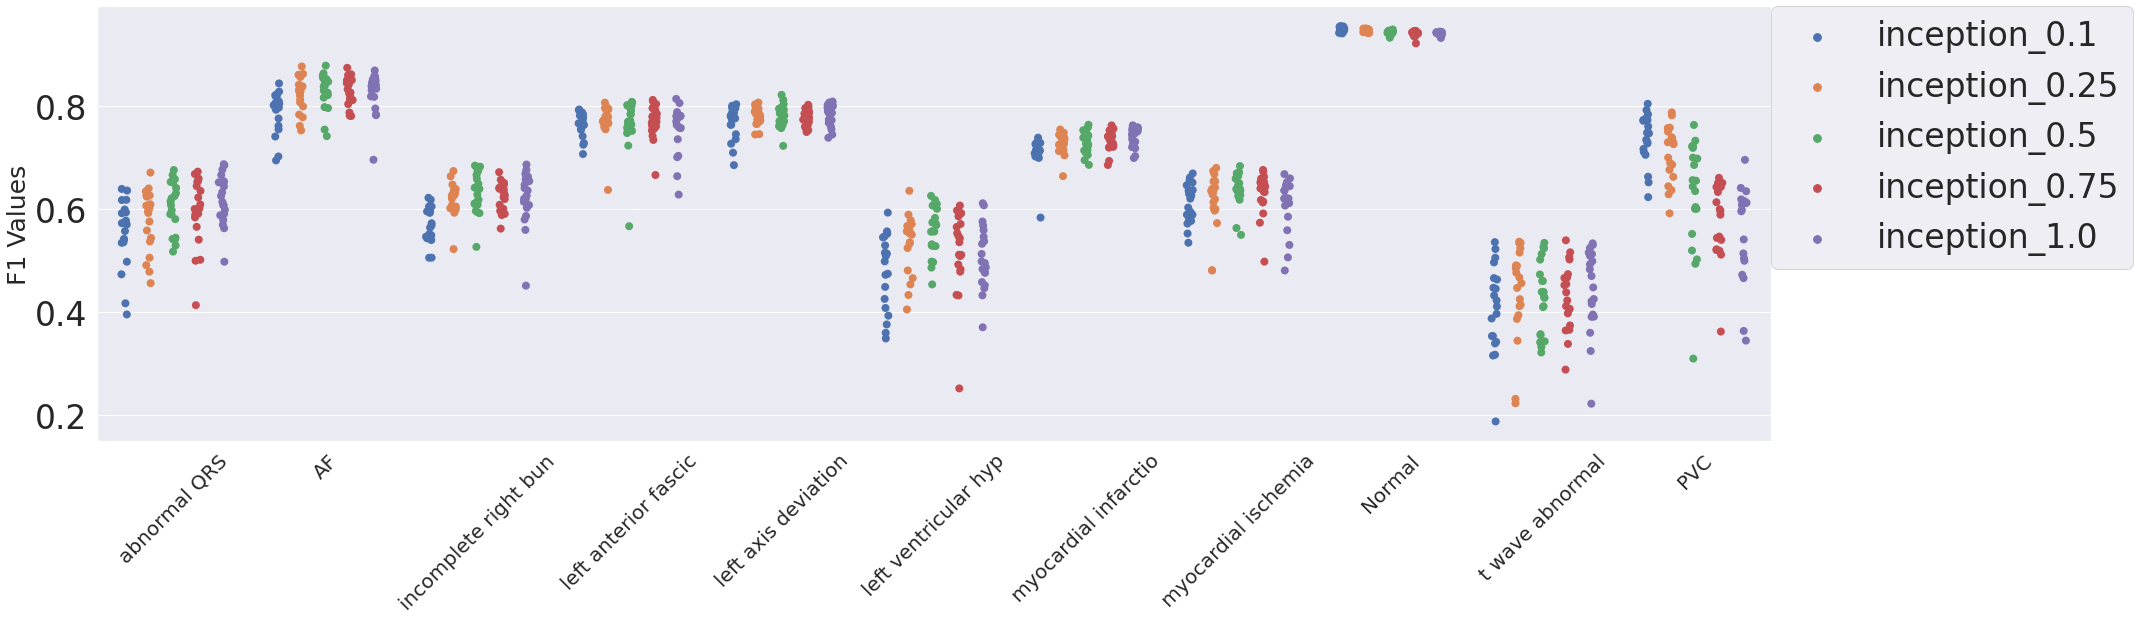

In [646]:
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

In [102]:
# compare inception and xresnet ( or any two models)
model_1 = "inception"
model_2 = "xresnet1d101"
exp_1 = get_scaling_experiments(model_1,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()
exp_2 = get_scaling_experiments(model_2,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()


In [103]:
# get difference between the 20 model experiments for each disease
pd.DataFrame(exp_2.values-exp_1.values,columns = exp_1.columns,index=[int(np.float32(x.split("_")[1])*500) for x in exp_1.index])

,abnormal QRS,atrial fibrillation,incomplete right bundle branch block,left anterior fascicular block,left axis deviation,left ventricular hypertrophy,myocardial infarction,myocardial ischemia,sinus rhythm,t wave abnormal,ventricular ectopics
50,-0.087908,-0.169038,-0.104308,-0.068199,-0.031581,-0.023549,-0.055027,-0.033129,-0.014154,-0.051400,-0.065706
125,-0.040984,-0.065734,-0.086180,-0.040735,-0.039938,-0.029012,-0.045959,-0.004005,-0.002055,-0.030761,-0.115769
250,-0.065410,-0.035533,-0.066724,-0.024761,-0.021755,-0.008554,-0.018887,-0.007129,0.002195,-0.034690,-0.077808
375,-0.020832,-0.007321,-0.041080,-0.022351,-0.022951,-0.009252,-0.034420,-0.044967,0.002015,-0.028257,0.016687
500,-0.040844,-0.010510,-0.038894,-0.037485,-0.027322,0.031746,-0.034012,-0.010982,0.003128,-0.049314,0.003131
